# CORE

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 12)
import matplotlib.pyplot as plt

In [4]:
from CarlaBEV.envs.utils import load_map

rgbmap, _, _ = load_map(size=1024)

print(f"Image Size: {rgbmap.shape}")

Image Size: (10240, 8192, 3)


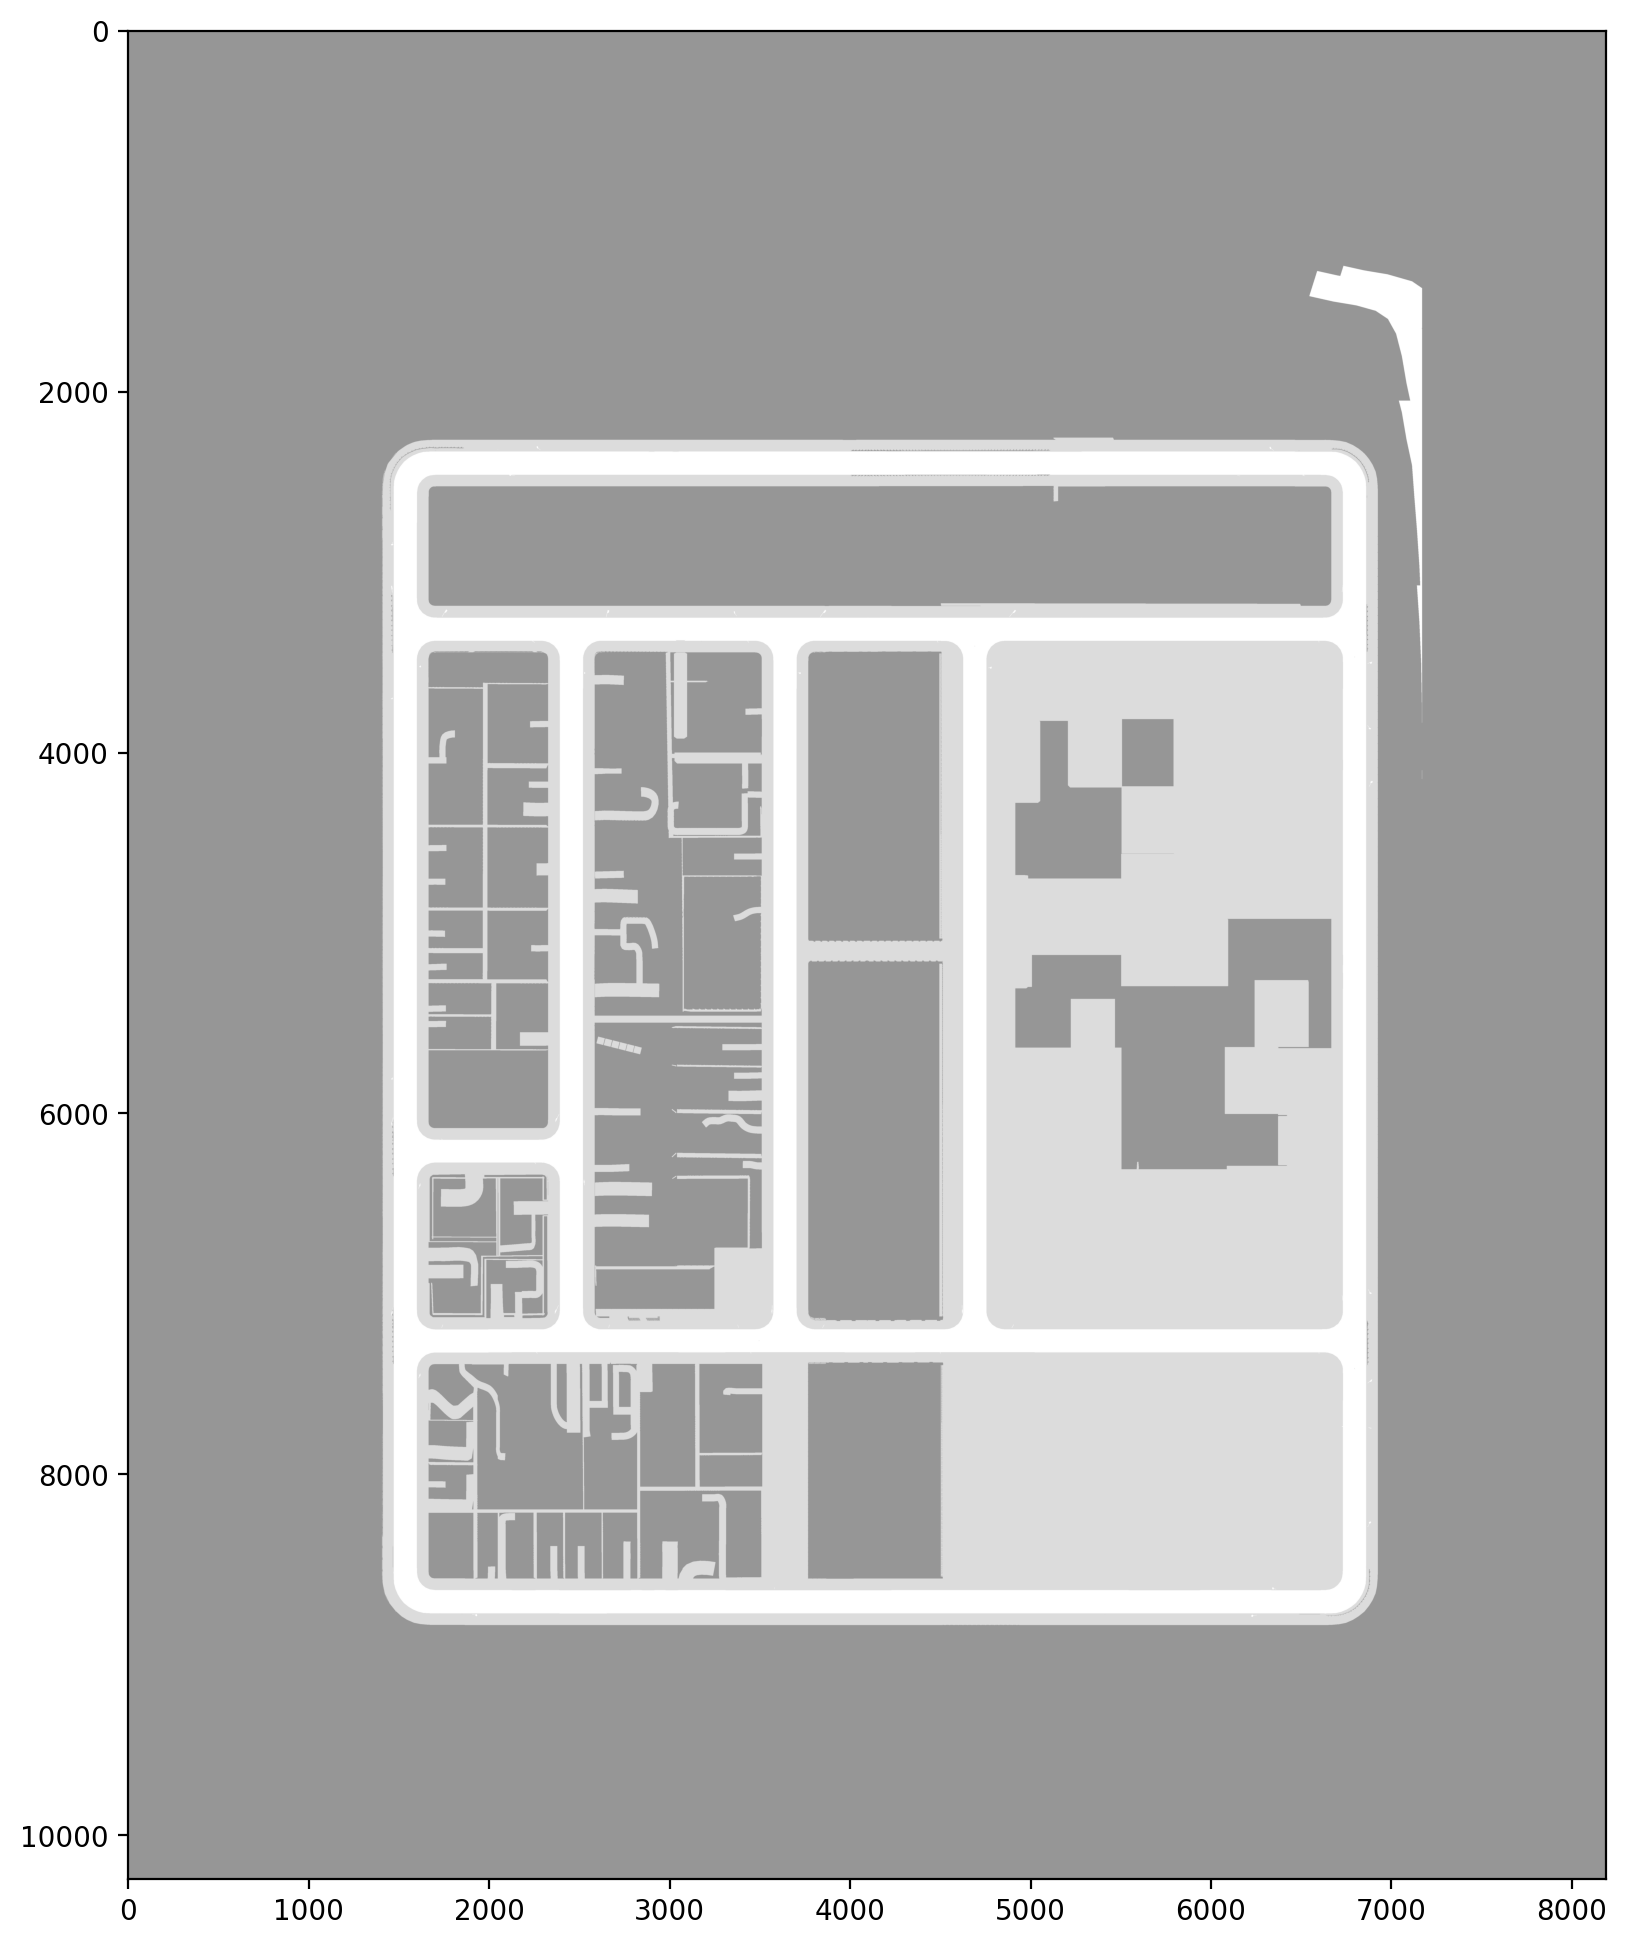

In [5]:
# Check map
plt.imshow(rgbmap)
plt.show()

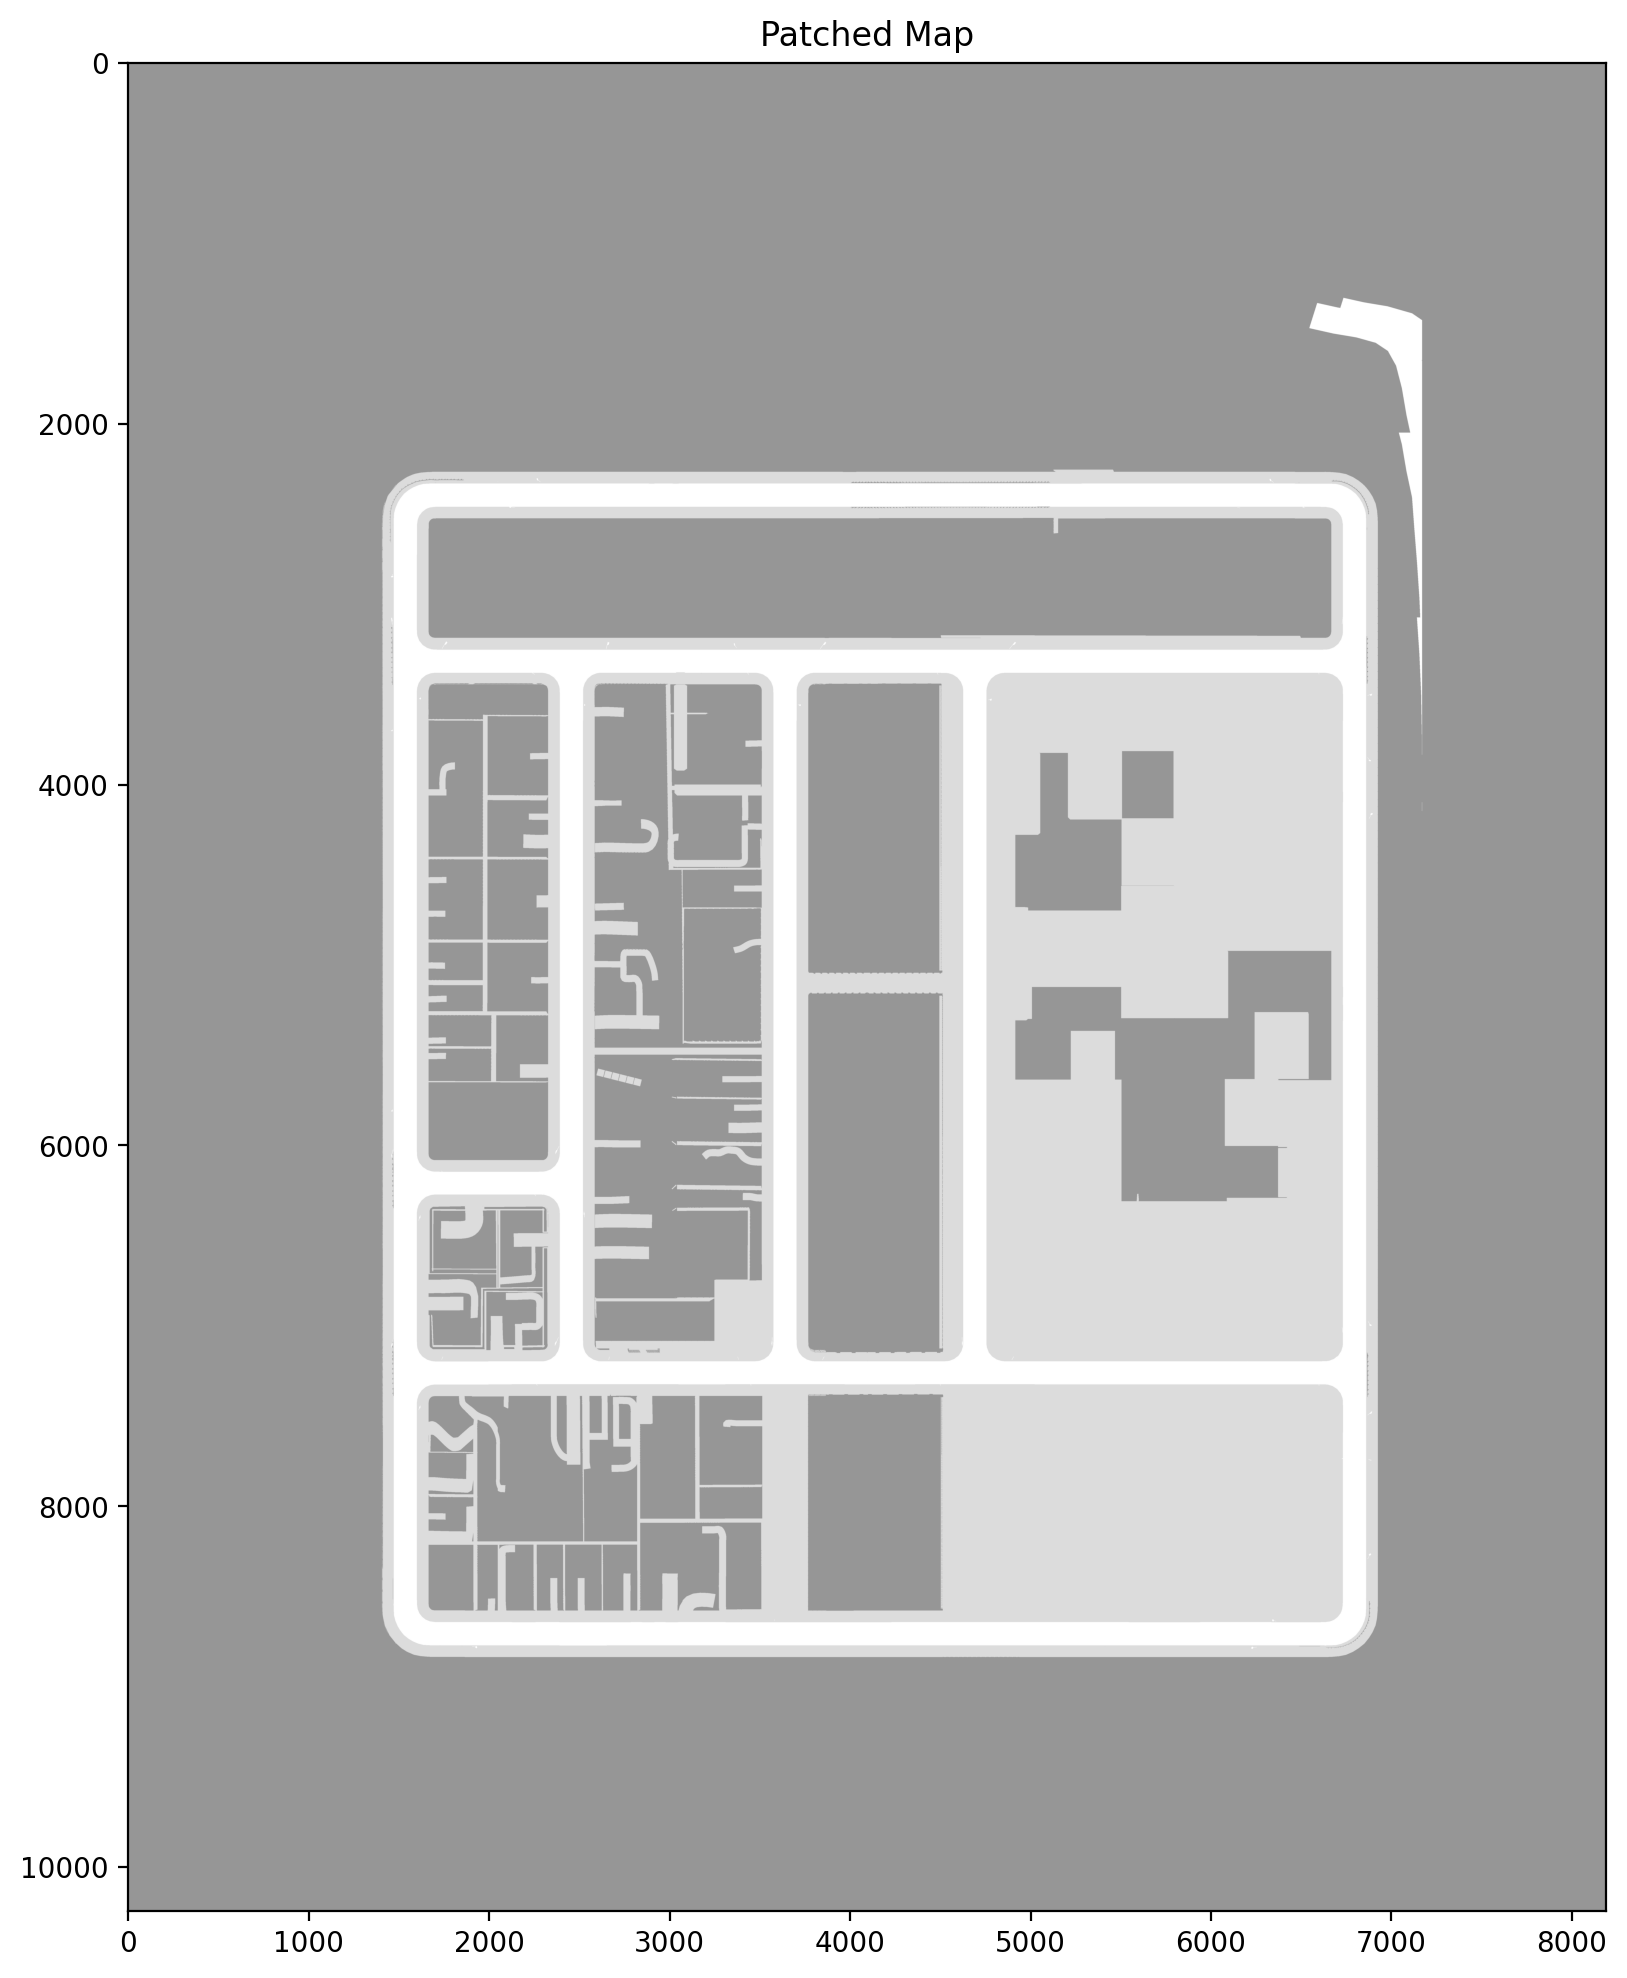

In [6]:
# Example: Patch a white rectangle at (y0, x0) with height h and width w

# If rgbmap is float [0,1], use 1.0; if uint8 [0,255], use 255
if rgbmap.dtype == np.uint8:
    white = 255
else:
    white = 1.0

y0, x0 = 7409, 6792    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 3466, 6792    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 7256, 3492    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

y0, x0 = 3406, 4689    # Top-left corner of the rectangle (change as needed)
h, w = 5, 5       # Height and width of the rectangle (change as needed)
rgbmap[y0:y0+h, x0:x0+w, :] = white

plt.imshow(rgbmap)
plt.title("Patched Map")
plt.show()

In [7]:
intersections = [
    (8642, 1564),
    (8654, 6755),
    (7250, 1552),
    (7241, 2446),
    (7242, 3652),
    (7242, 4704),
    (7257, 6773),
    (6199, 1552),
    (6197, 2439),
    (3349, 1545),
    (3350, 2456),
    (3350, 3639),
    (3335, 4714),
    (3315, 6773),
    (2456, 1563),
    (2446, 6757),
 ]

intersections = [(y, x) for x, y in intersections]

In [8]:
map_edges = {}
for i, coord in enumerate(intersections):
    x, y = coord
    map_edges[i] = (x, y)

In [9]:
from skimage.color import rgb2gray
from skimage.morphology import skeletonize

def get_midlane_coords(rgbmap):
    gray = rgb2gray(rgbmap)
    binary = gray > 0.99  # Adjust threshold if needed
    # Skeletonize to get lane centerlines
    skeleton = skeletonize(binary)
    # Get coordinates of skeleton pixels (centerline points)
    centerline_coords = np.argwhere(skeleton)
    return centerline_coords

def sample_equidistant_points(path_coords, step=100):
    """Given a list of (y, x) coords, return equidistant points along the path."""
    path_coords = np.array(path_coords)
    # Compute cumulative distance along the path
    deltas = np.diff(path_coords, axis=0)
    dists = np.sqrt((deltas**2).sum(axis=1))
    cumdist = np.insert(np.cumsum(dists), 0, 0)
    total_dist = cumdist[-1]
    n_points = int(total_dist // step)
    if n_points < 2:
        return path_coords  # Path too short, return as is
    sample_dists = np.linspace(0, total_dist, n_points)
    sampled_points = np.empty((n_points, 2))
    sampled_points[0] = path_coords[0]
    sampled_points[-1] = path_coords[-1]
    j = 1
    for i in range(1, n_points-1):
        d = sample_dists[i]
        while cumdist[j] < d:
            j += 1
        ratio = (d - cumdist[j-1]) / (cumdist[j] - cumdist[j-1])
        sampled_points[i] = path_coords[j-1] + ratio * (path_coords[j] - path_coords[j-1])
    return sampled_points.astype(int)

def get_route_waypoints(pixel_graph, node_a, node_b ):
    # 2. For each consecutive pair, find pixel path and discretize
    pixel_path = nx.shortest_path(pixel_graph, node_a, node_b)
    waypoints = sample_equidistant_points(pixel_path, step=300)  # step in pixels
    return waypoints

def compute_lane_offsets(waypoints, lane_width=6.0):
    """
    Given centerline waypoints (N,2), return left and right lane waypoints.
    lane_width: total width of both lanes (in pixels, adjust as needed)
    """
    waypoints = np.array(waypoints)
    left_lane = []
    right_lane = []
    side_1, side_2 = [], []
    offset = lane_width / 2.0
    offset_ped = lane_width + 10

    for i in range(len(waypoints)):
        # Compute direction vector
        if i == 0:
            direction = waypoints[i+1] - waypoints[i]
        elif i == len(waypoints) - 1:
            direction = waypoints[i] - waypoints[i-1]
        else:
            direction = waypoints[i+1] - waypoints[i-1]
        direction = direction / np.linalg.norm(direction)
        # Normal vector (perpendicular, 2D)
        normal = np.array([-direction[1], direction[0]])
        # Offset points
        left_lane.append(waypoints[i] + offset * normal)
        right_lane.append(waypoints[i] - offset * normal)
        side_1.append(waypoints[i] + offset_ped * normal)
        side_2.append(waypoints[i] - offset_ped * normal)
    return np.array(left_lane), np.array(right_lane), np.array(side_1), np.array(side_2)


In [10]:
def show_route(rgbmap, waypoints):
    # 3. Visualize the full route
    plt.imshow(rgbmap)
    for idx, p in enumerate(intersections):
        plt.scatter(p[1], p[0], c='red', s=80, zorder=3)
        plt.annotate(str(idx), (p[1], p[0]), color='k', fontsize=12, weight='bold', zorder=4)
    plt.plot(waypoints[:,1], waypoints[:,0], 'orange', lw=2, zorder=5, label='Discretized Route')
    plt.scatter(waypoints[:,1], waypoints[:,0], c='b', s=1, zorder=6, label='Waypoints')
    plt.axis('off')
    plt.legend()
    plt.show()

In [11]:
centerline_coords = get_midlane_coords(rgbmap)
centerline_coords = centerline_coords[:, [1, 0]]

In [12]:
# 1. Find the closest centerline point for each intersection
intersection_nodes = []
for intersection in intersections:
    dists = np.linalg.norm(centerline_coords - intersection, axis=1)
    idx_min = np.argmin(dists)
    intersection_nodes.append(tuple(centerline_coords[idx_min]))

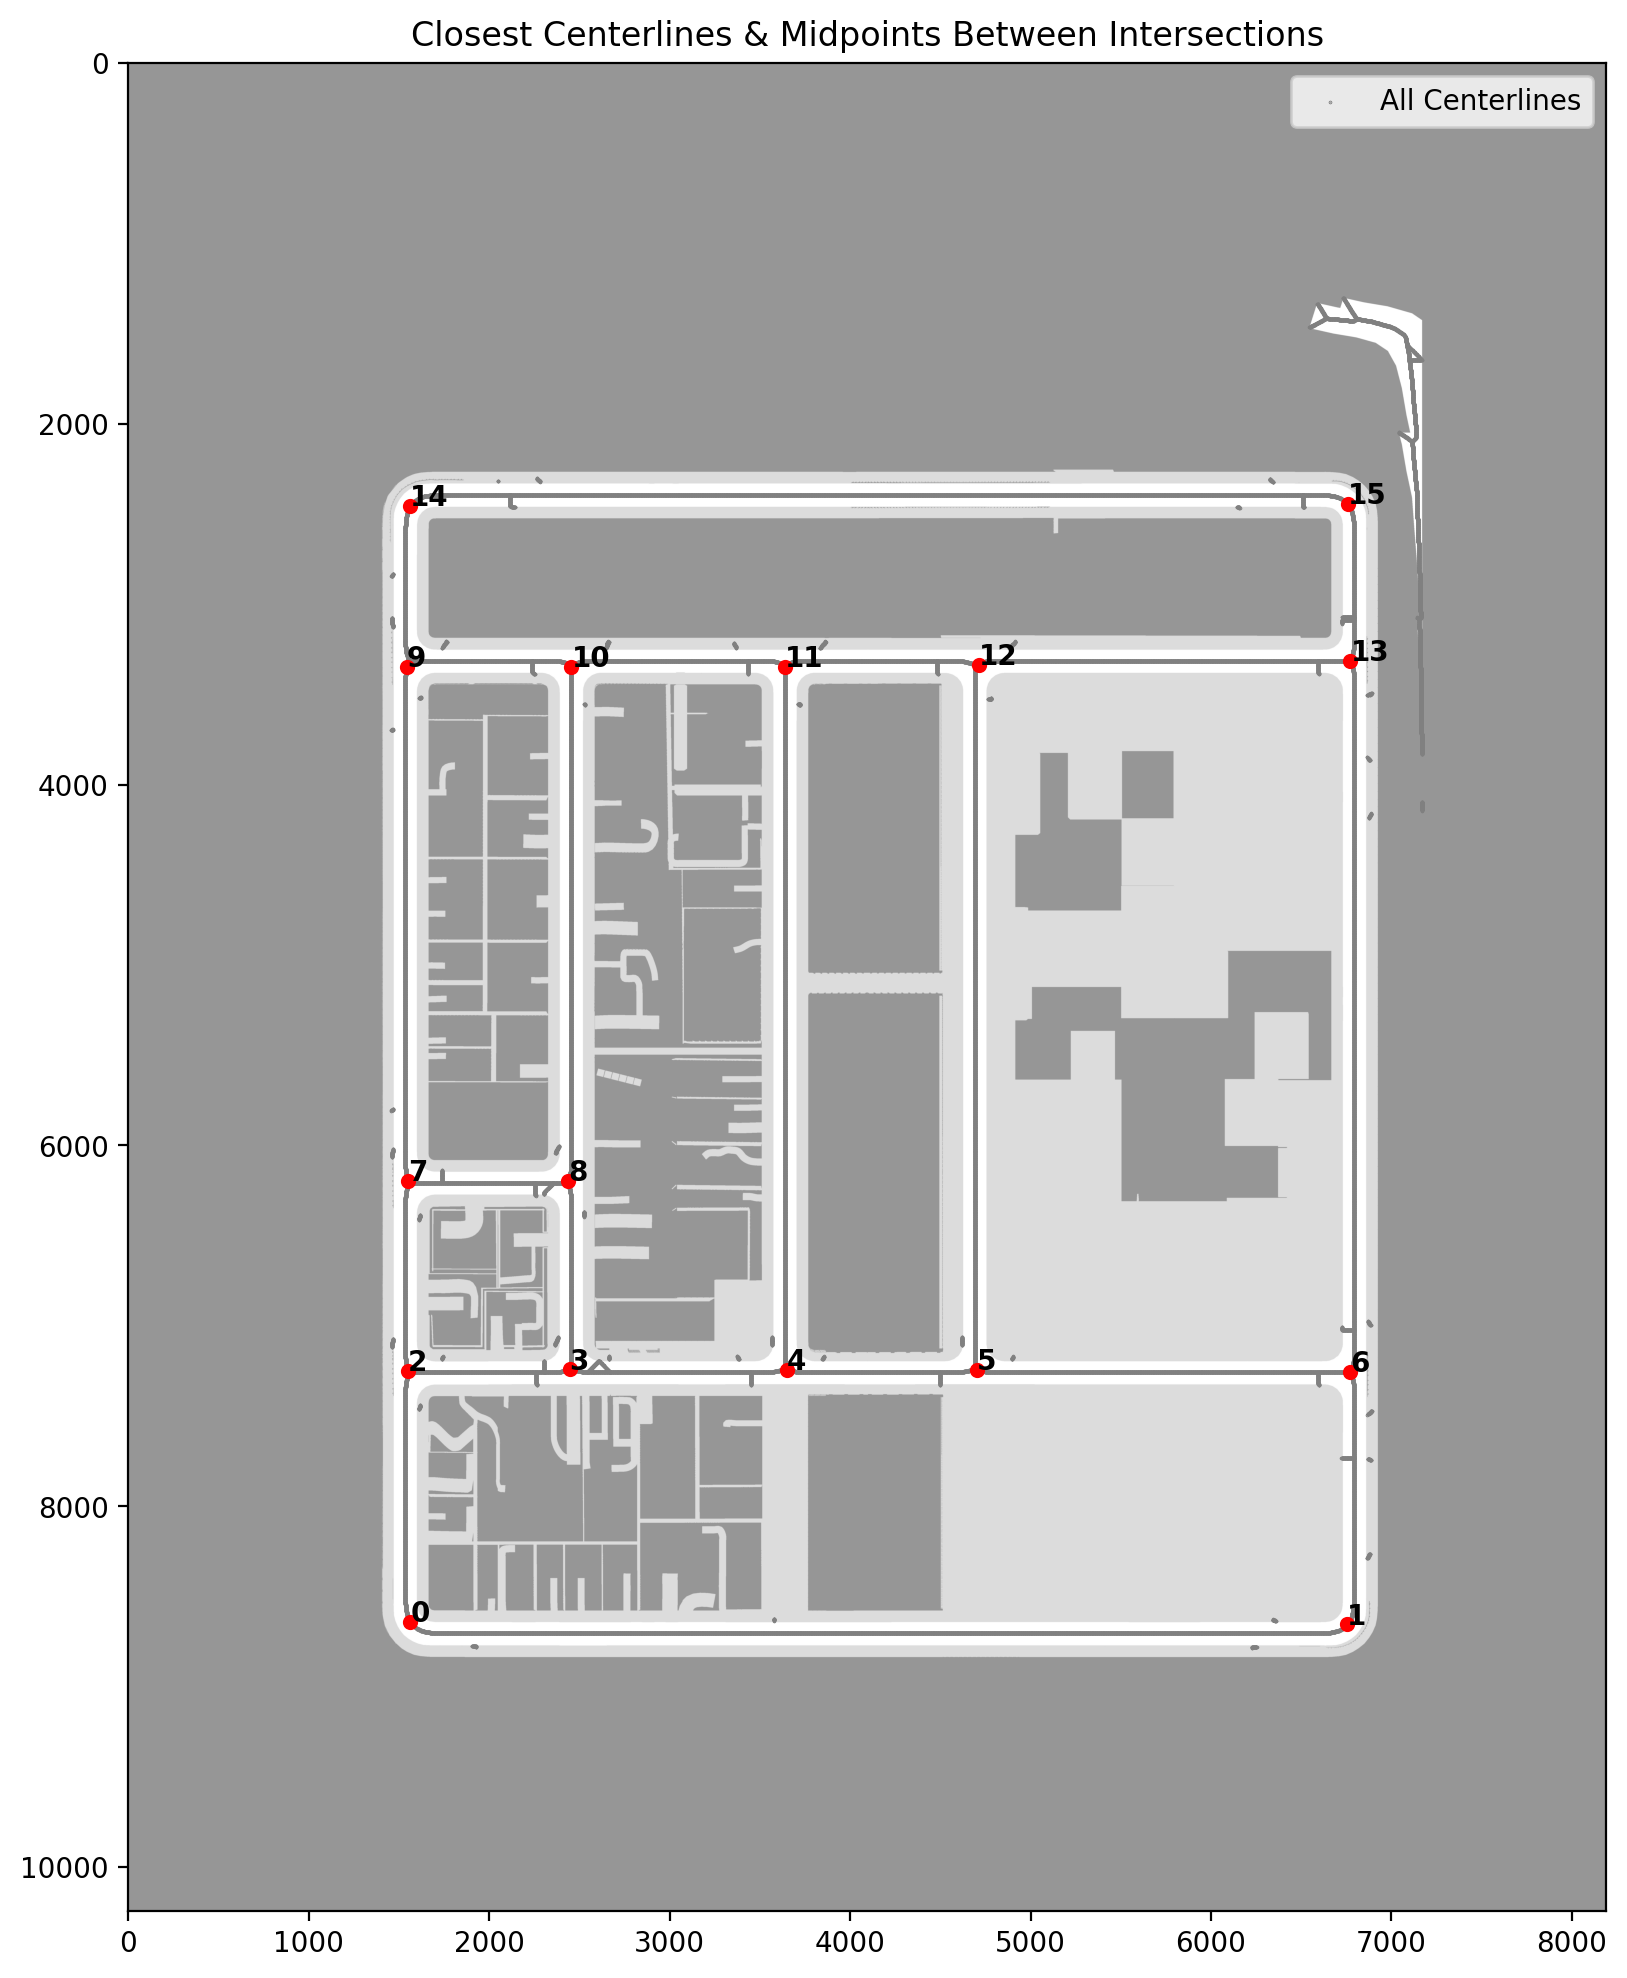

In [13]:
plt.imshow(rgbmap)
plt.scatter(centerline_coords[:,0], centerline_coords[:,1], c='gray', s=0.1, label='All Centerlines')
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=20)
    plt.annotate(str(idx), (p[0], p[1]), color='k', fontsize=10, weight='bold')
plt.legend()
plt.title("Closest Centerlines & Midpoints Between Intersections")
plt.show()

Direct intersection pairs (by index): [(0, 1), (0, 2), (1, 6), (2, 3), (2, 7), (3, 4), (3, 8), (4, 5), (4, 11), (5, 6), (5, 12), (6, 13), (7, 8), (7, 9), (8, 10), (9, 10), (9, 14), (10, 11), (11, 12), (12, 13), (13, 15), (14, 15)]


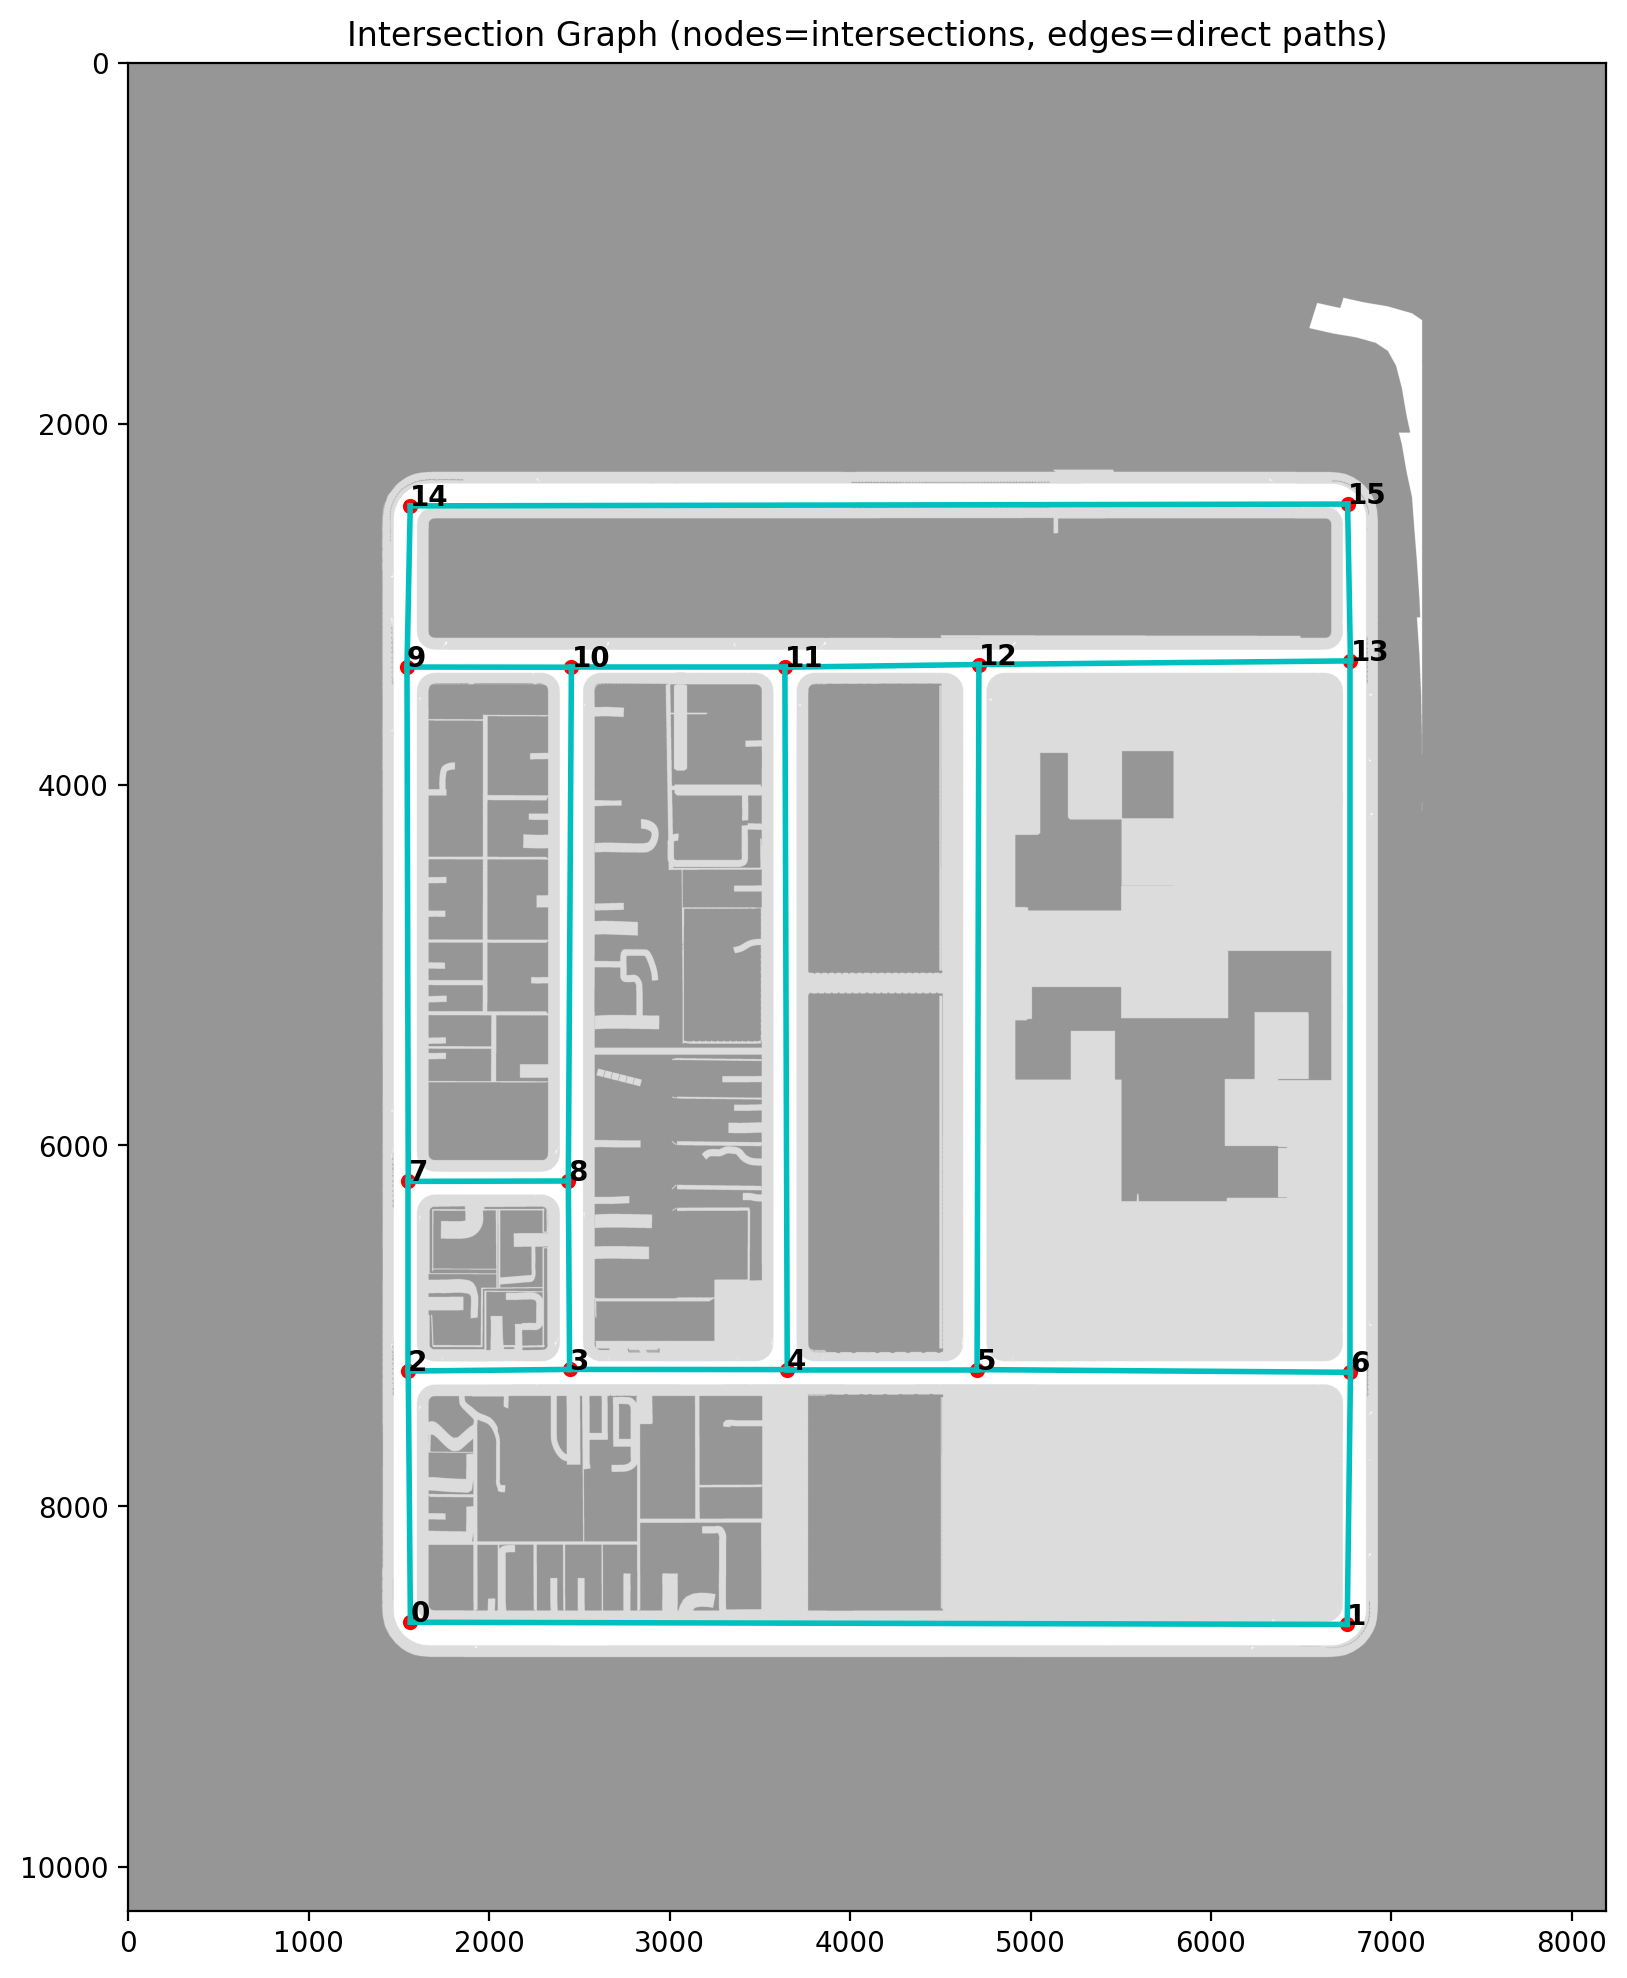

In [14]:
# 2. Build a pixel adjacency graph for centerline_coords (for pathfinding only)
pixel_graph = nx.Graph()
centerline_set = set(map(tuple, centerline_coords))
for y, x in centerline_coords:
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue
            neighbor = (y + dy, x + dx)
            if neighbor in centerline_set:
                pixel_graph.add_edge((y, x), neighbor)

# 3. Precompute a set of "blocked" pixels for each intersection (within a radius)
block_radius = 100  # pixels
blocked_pixels = []
for node in intersection_nodes:
    y0, x0 = node
    pixels = set()
    for dy in range(-block_radius, block_radius+1):
        for dx in range(-block_radius, block_radius+1):
            if dy**2 + dx**2 <= block_radius**2:
                pixels.add((y0+dy, x0+dx))
    blocked_pixels.append(pixels)

# 4. Build the intersection graph
G_intersections = nx.Graph()
for idx in range(len(intersections)):
    G_intersections.add_node(idx, pos=intersections[idx])

for i, node_a in enumerate(intersection_nodes):
    for j, node_b in enumerate(intersection_nodes):
        if i < j:
            try:
                path = nx.shortest_path(pixel_graph, node_a, node_b)
                path_set = set(path[1:-1])
                blocked = False
                for k, block in enumerate(blocked_pixels):
                    if k != i and k != j and path_set & block:
                        blocked = True
                        break
                if not blocked:
                    G_intersections.add_edge(i, j)
            except nx.NetworkXNoPath:
                continue

print("Direct intersection pairs (by index):", list(G_intersections.edges))

# Visualization
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=20)
    plt.annotate(str(idx), (p[0], p[1]), color='k', fontsize=10, weight='bold')
for i, j in G_intersections.edges:
    a = intersections[i]
    b = intersections[j]
    plt.plot([a[0], b[0]], [a[1], b[1]], 'c-', lw=2)
plt.title("Intersection Graph (nodes=intersections, edges=direct paths)")
plt.show()

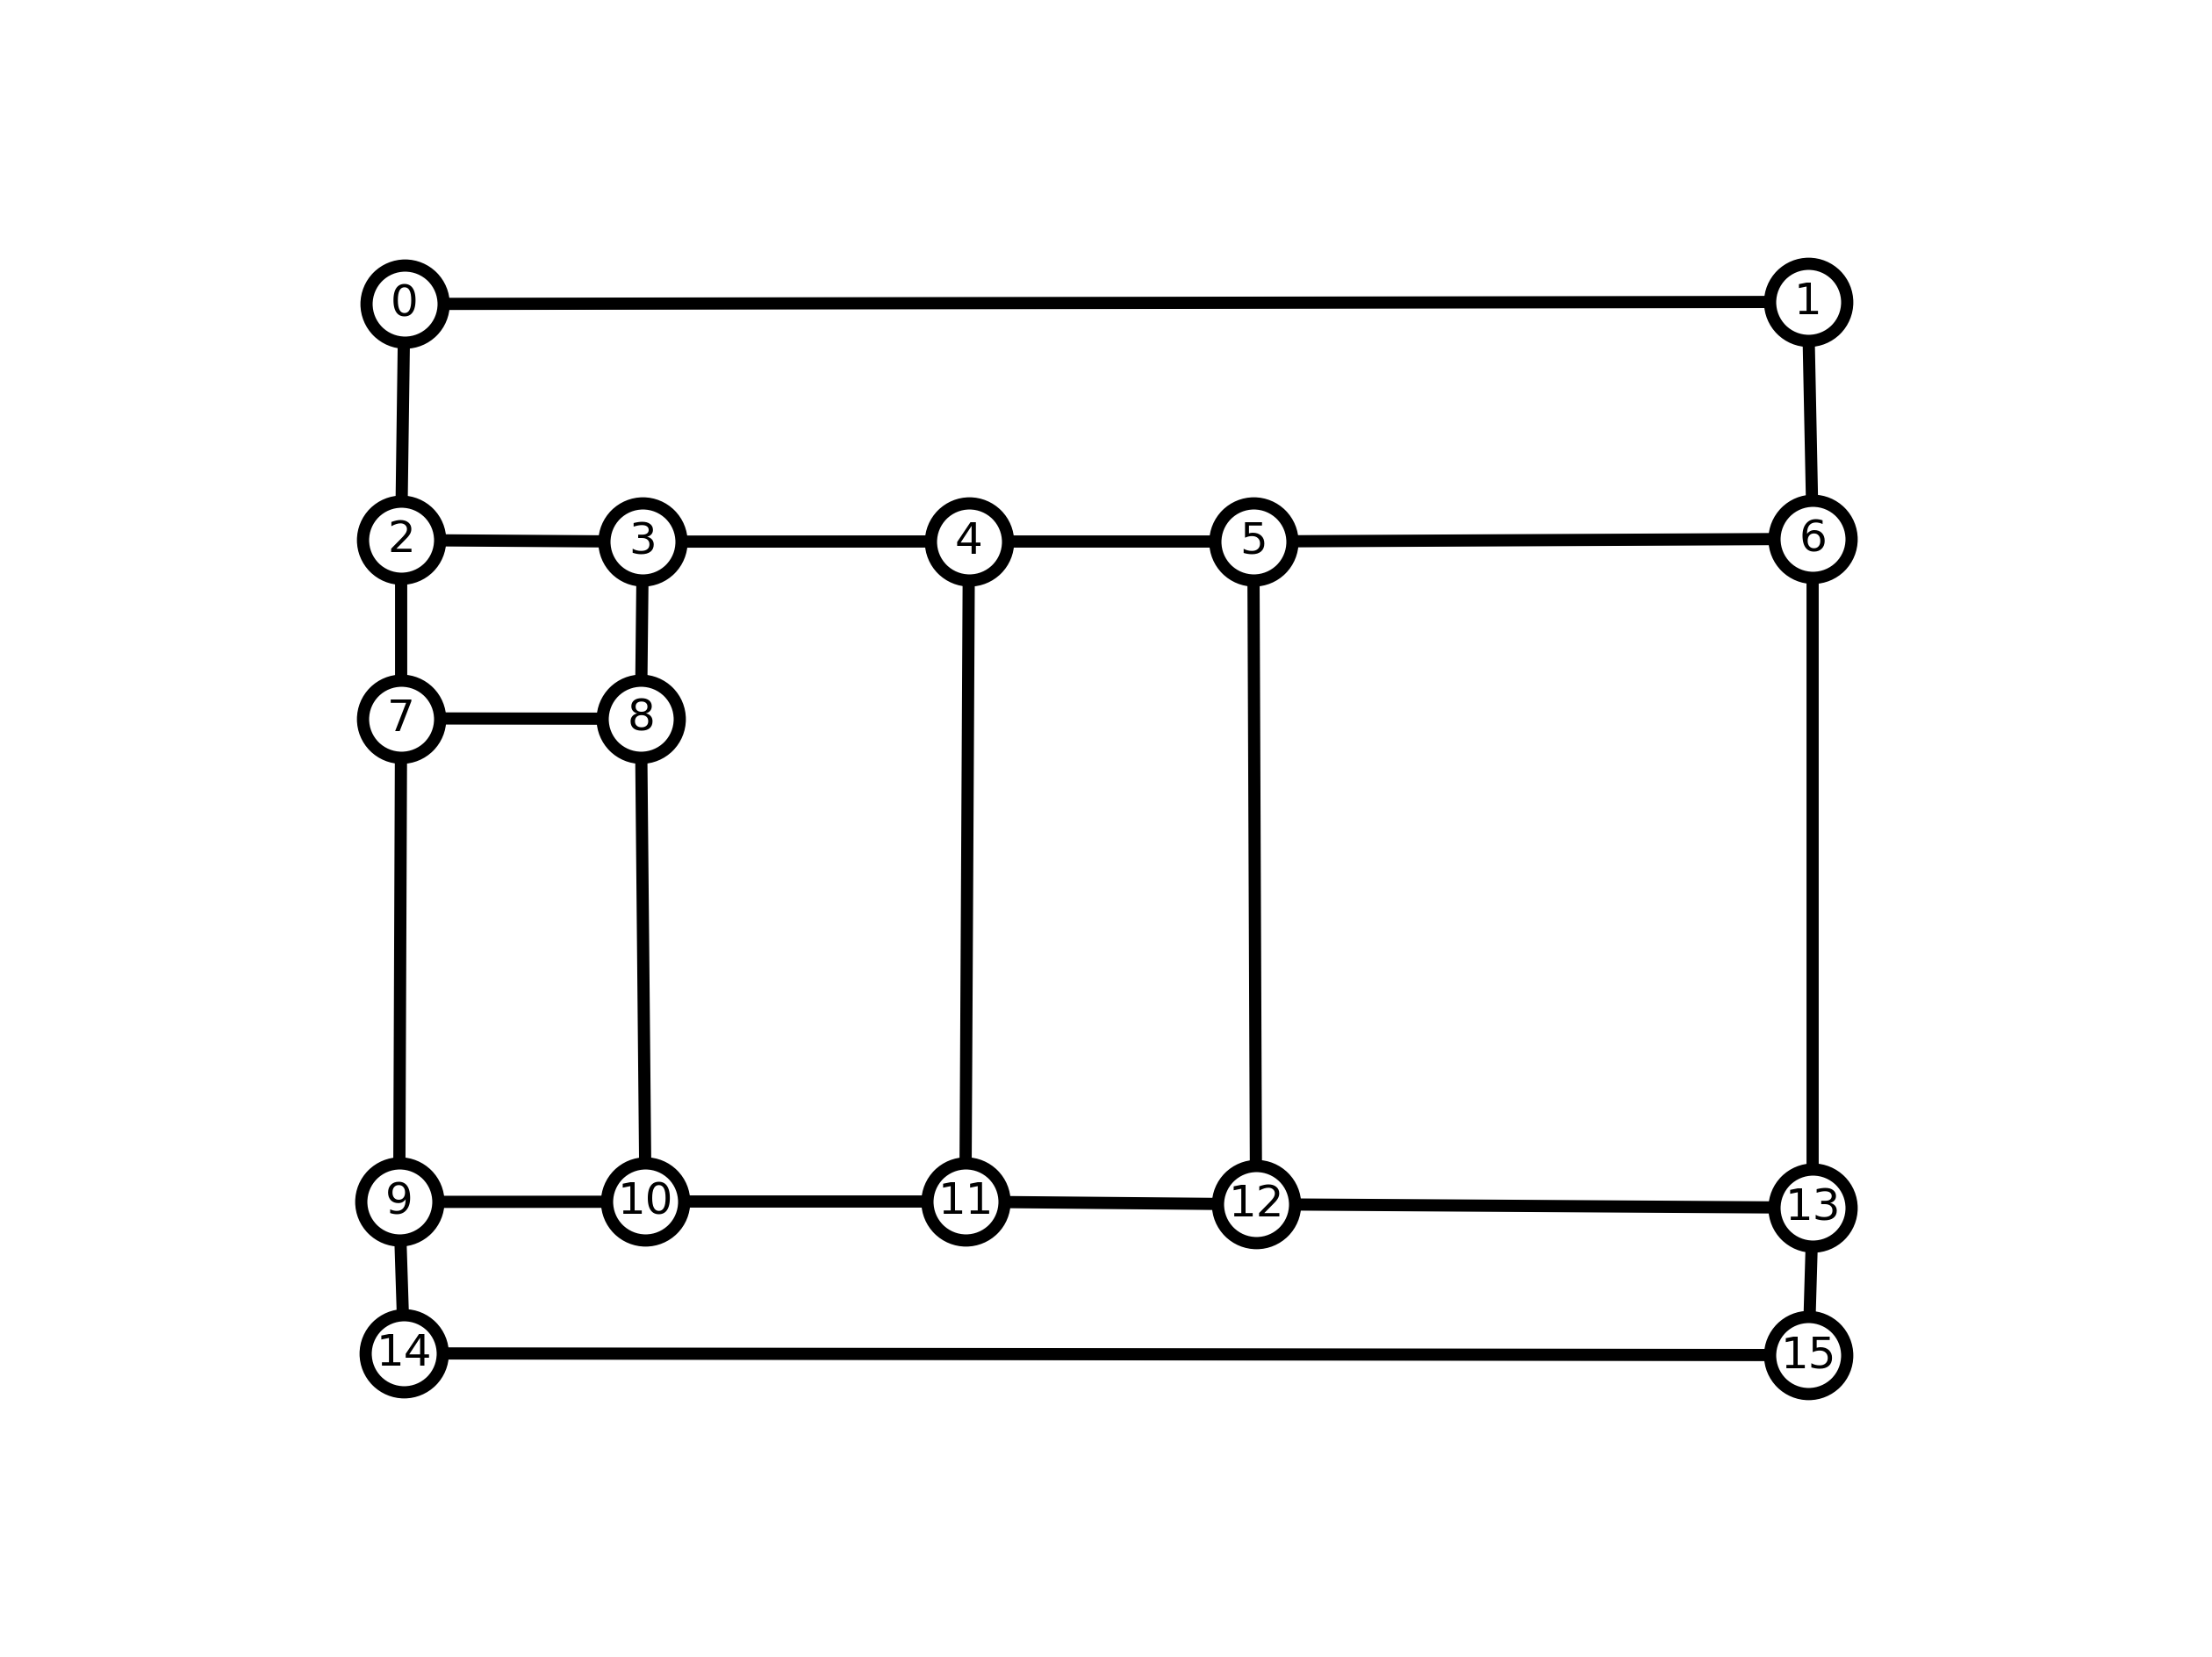

In [15]:
options = {
    "font_size": 18,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw_networkx(G_intersections, map_edges, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [16]:
# Usage
lane_width_pixels = 80  # Adjust to your map's scale

# Example: Discretize all edges in G_intersections
edge_waypoints = {}
edge_lanes_r = {}
edge_lanes_l = {}
for i, j in G_intersections.edges:
    node_a = intersection_nodes[i]
    node_b = intersection_nodes[j]
    # Get the pixel path between intersections
    path = nx.shortest_path(pixel_graph, node_a, node_b)
    # Sample equidistant points (e.g., every n pixels)
    waypoints = sample_equidistant_points(path, step=100)

    left_lane, right_lane, side1, side2 = compute_lane_offsets(waypoints, lane_width=lane_width_pixels)
    edge_waypoints[(i, j)] = waypoints
    edge_lanes_r[(i, j)] = right_lane 
    edge_lanes_l[(i, j)] = left_lane 

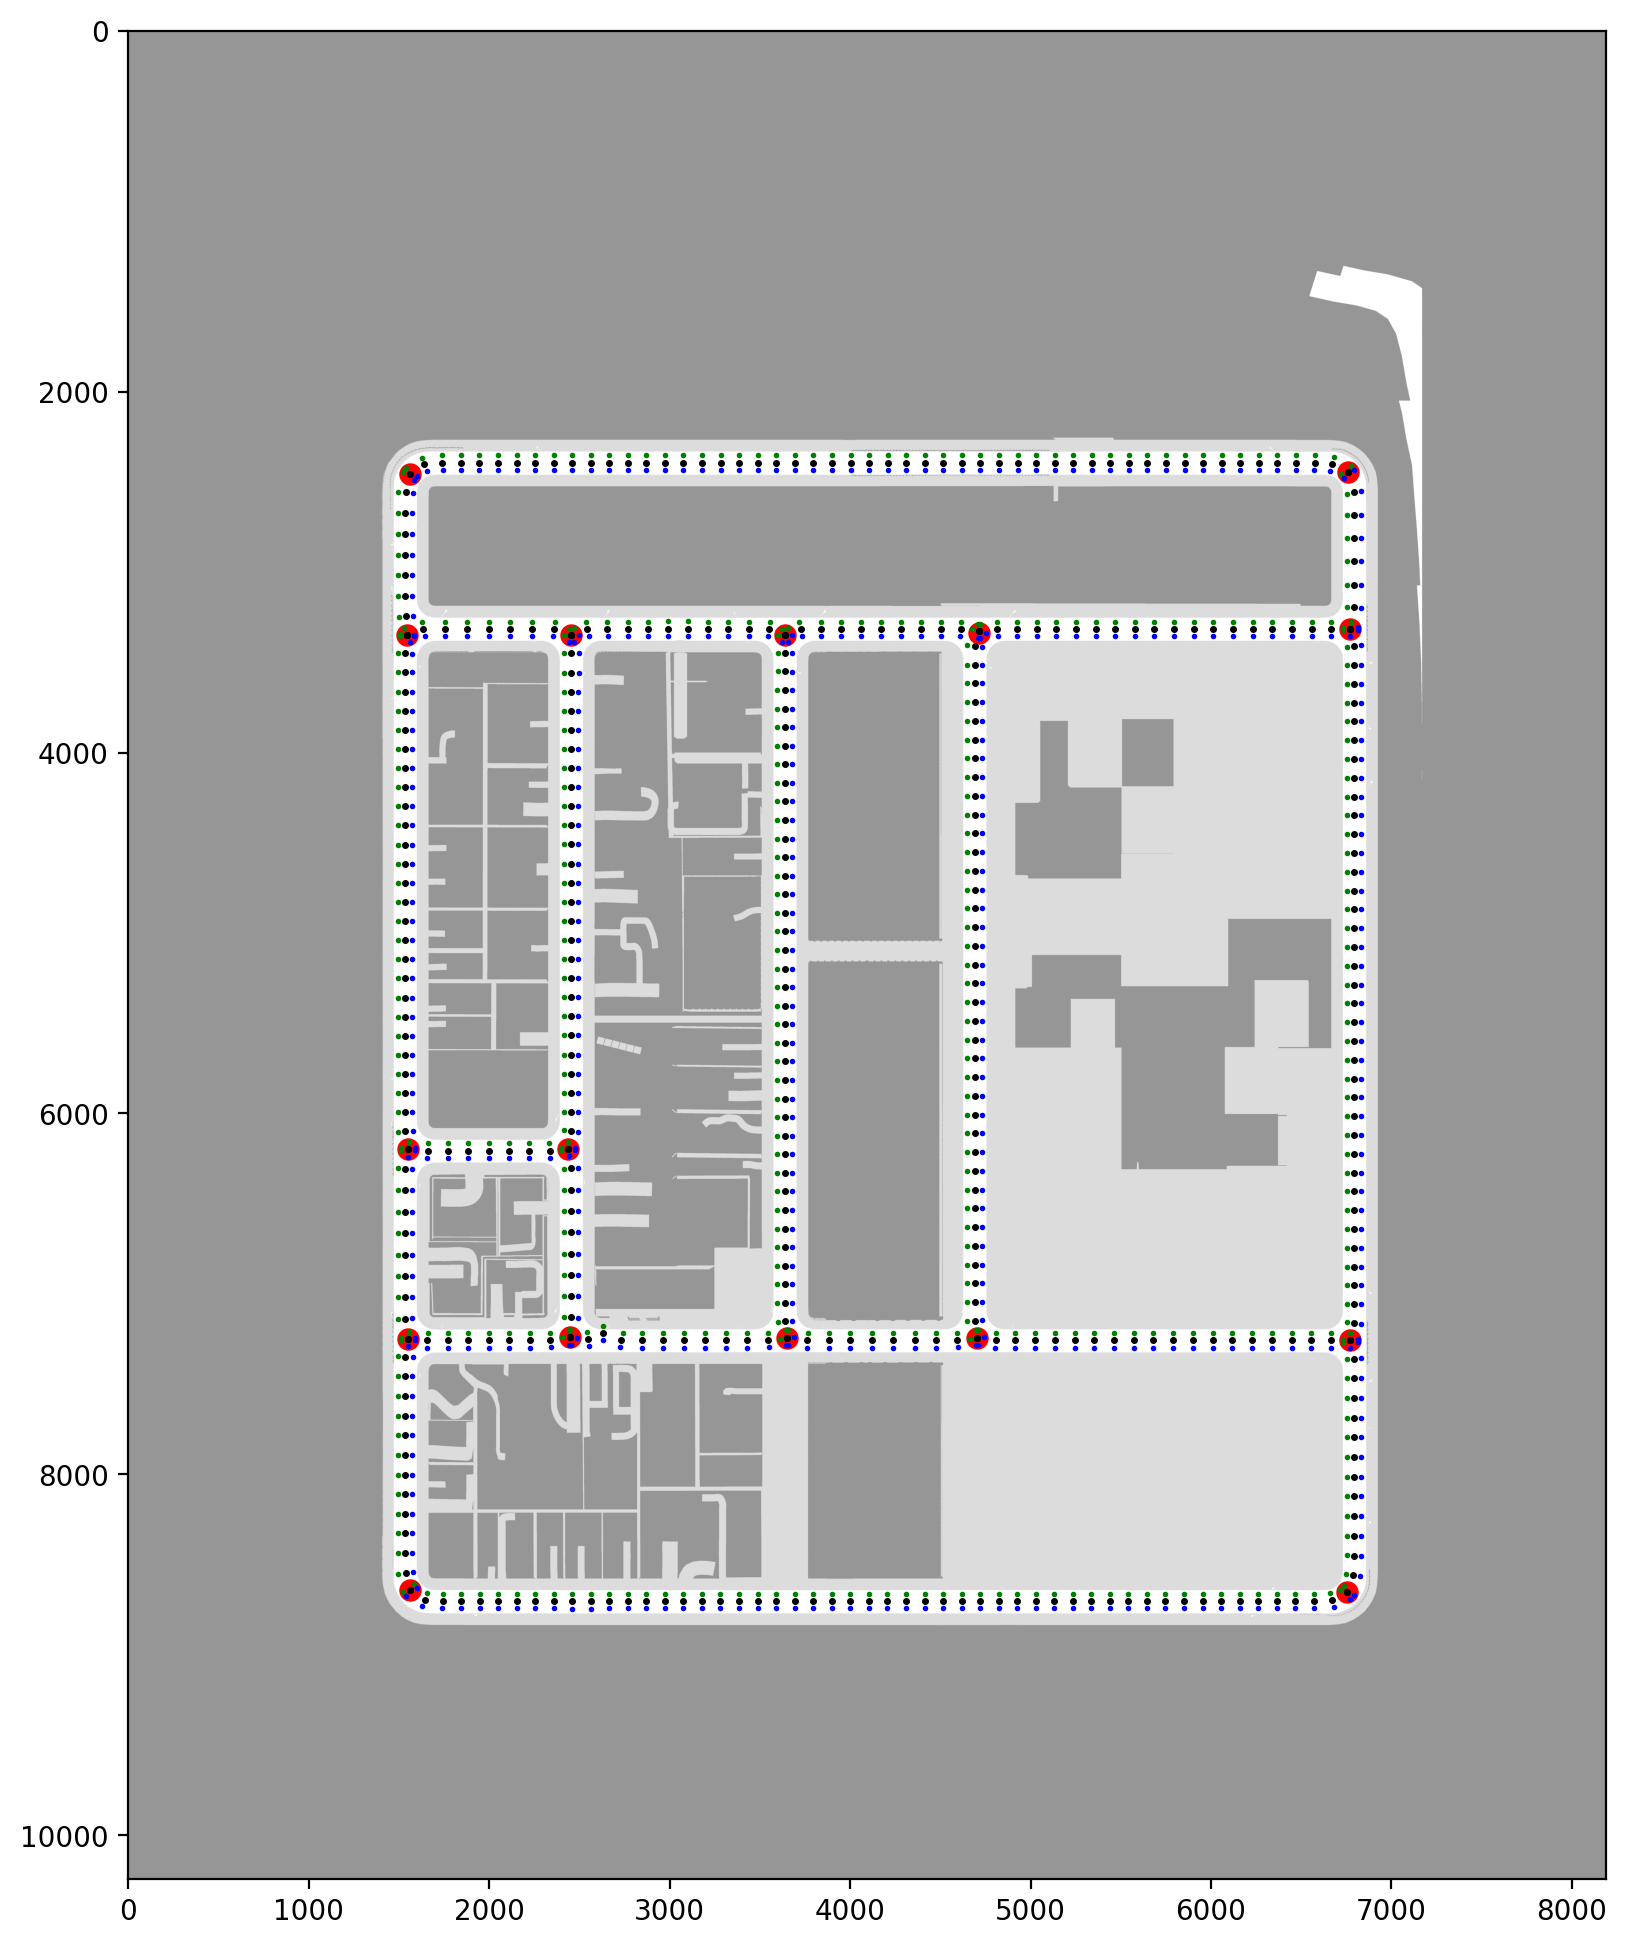

In [18]:
# Visualize one edge's waypoints
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=50)

for (i, j), waypoints in edge_waypoints.items():
    plt.plot(waypoints[:,0], waypoints[:,1], 'k.', markersize=3)

for (i, j), waypoints in edge_lanes_r.items():
    plt.plot(waypoints[:,0], waypoints[:,1], 'g.', markersize=2)

for (i, j), waypoints in edge_lanes_l.items():
    plt.plot(waypoints[:,0], waypoints[:,1], 'b.', markersize=2)

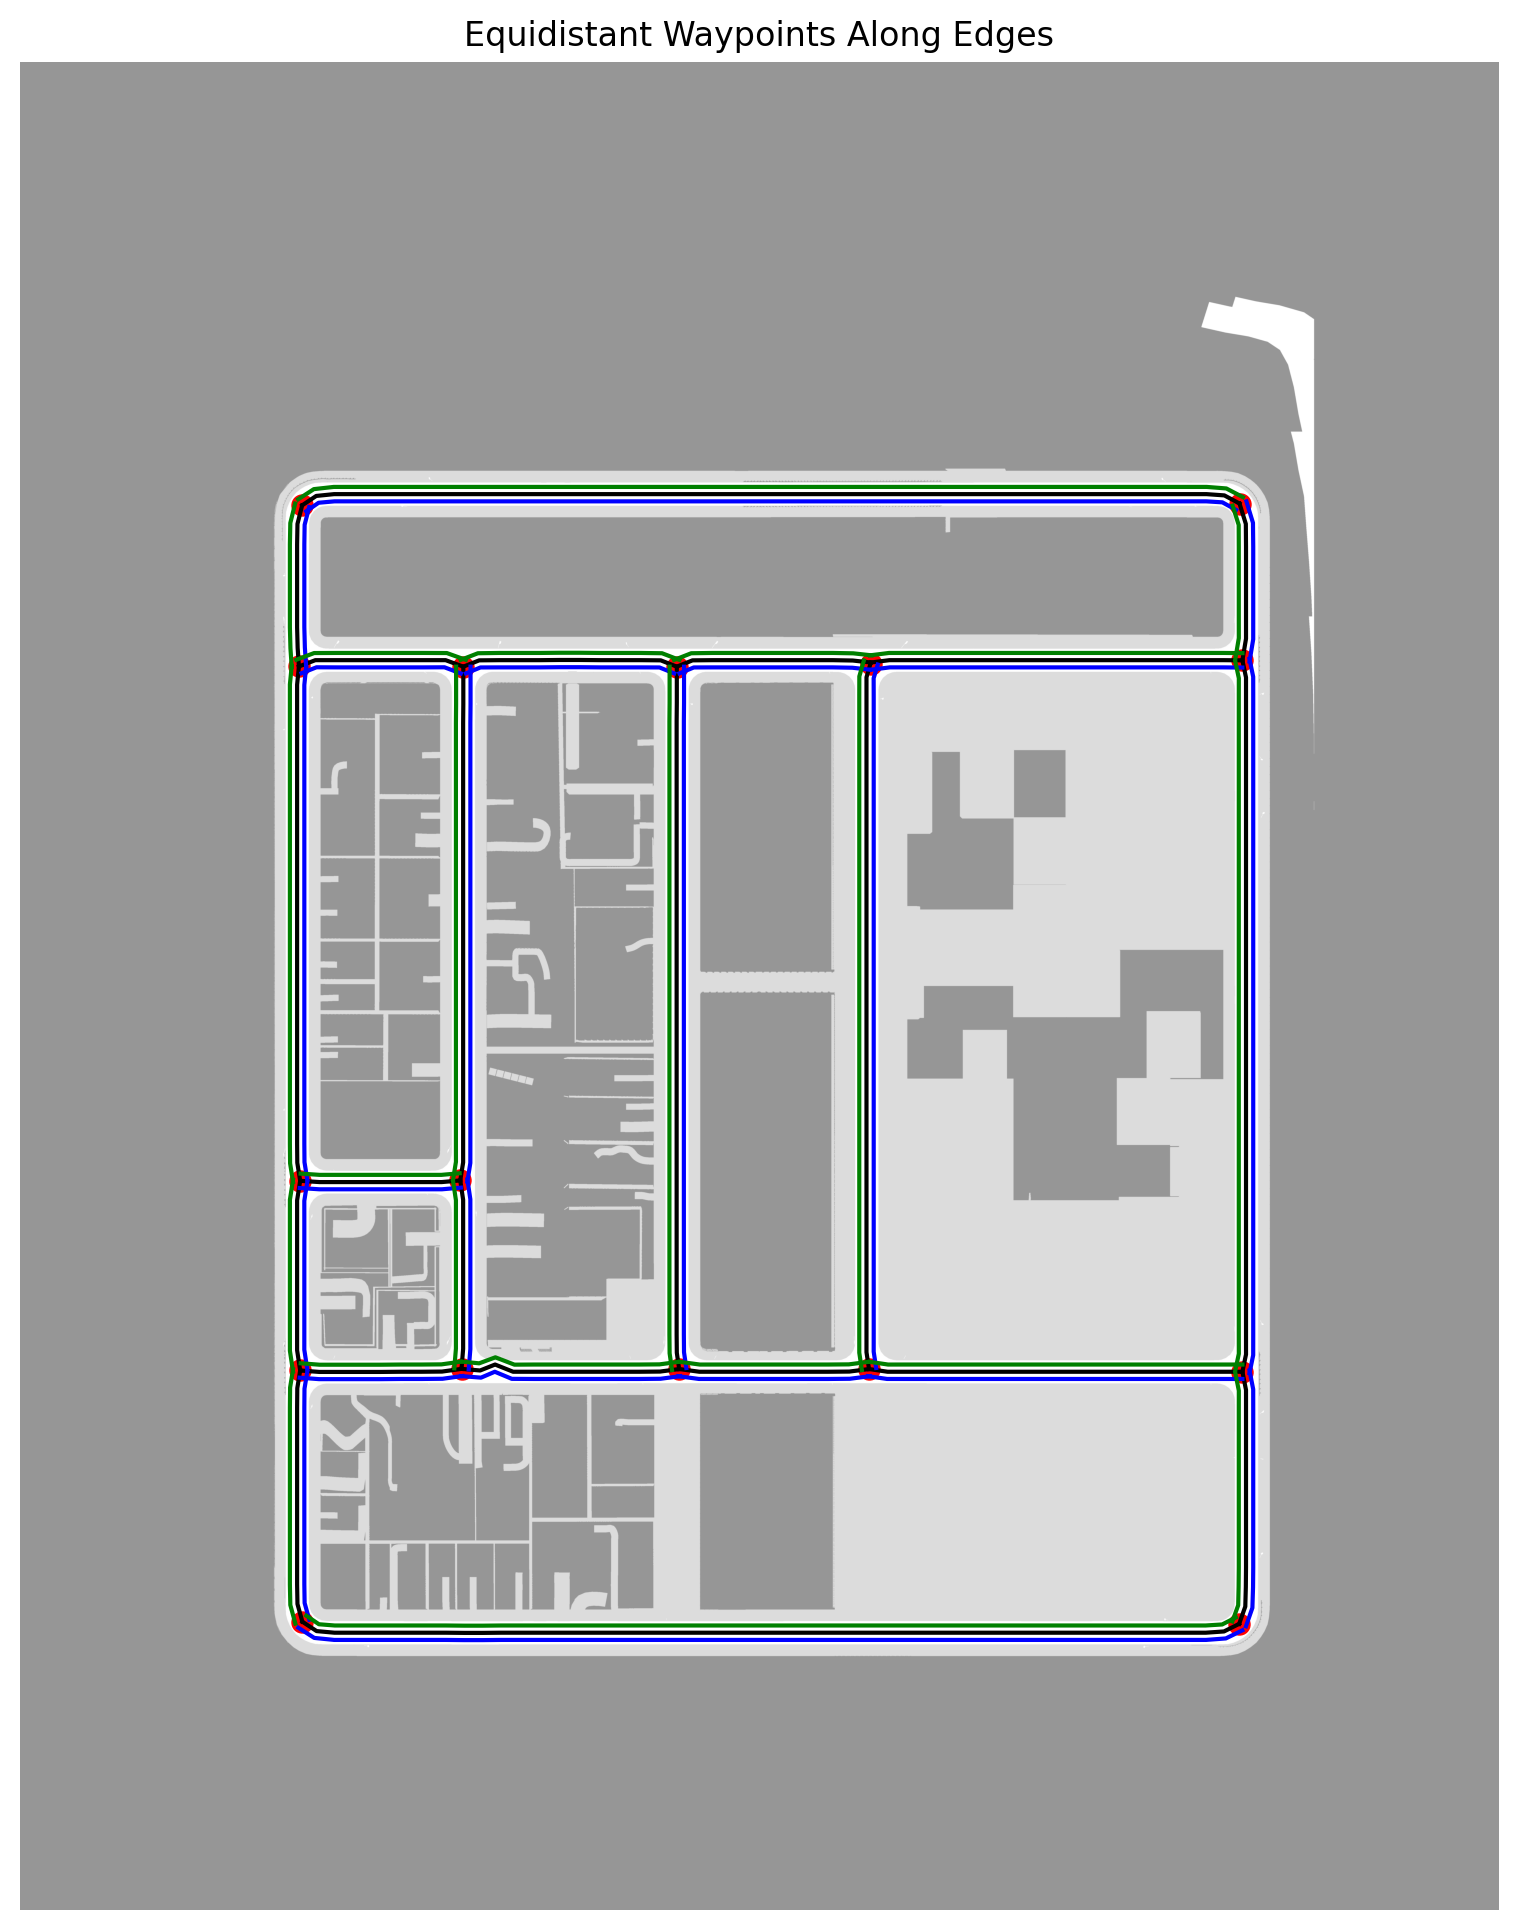

In [19]:
# Visualize one edge's waypoints
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=50)

for (i, j), waypoints in edge_waypoints.items():
    plt.plot(waypoints[:,0], waypoints[:,1], 'k-', markersize=4)

for (i, j), waypoints in edge_lanes_l.items():
    plt.plot(waypoints[:,0], waypoints[:,1], 'b-', markersize=4)

for (i, j), waypoints in edge_lanes_r.items():
    plt.plot(waypoints[:,0], waypoints[:,1], 'g-', markersize=4)

plt.title("Equidistant Waypoints Along Edges")
plt.axis('off')
plt.show()

In [18]:
def get_closest_node(graph, point):
    # Assume graph nodes are (x, y) tuples
    return min(graph.nodes, key=lambda n: (n[0] - point[0])**2 + (n[1] - point[1])**2)


# GENERATE GRAPH!!!

In [72]:
import networkx as nx
import matplotlib.pyplot as plt

# --- Parameters ---
lane_width_pixels = 80  # Adjust to your map's scale
sample_step = 100       # Step size for waypoint sampling
add_lanes = False

# --- Containers ---
edge_waypoints = {}
edge_lanes_r = {}
edge_lanes_l = {}

# --- Full planning graph ---
G_center = G_intersections.copy()
G_left = G_intersections.copy()
G_right = G_intersections.copy()

In [73]:
def add_center_waypoints(G, edge_id, centerline, cost_forward=1.0, lane="C", cost_to_intersection=0.1):
    """
    Adds centerline waypoints and connects them to intersection nodes.
    
    Parameters:
        G : networkx.Graph
            The planning graph to modify.
        edge_id : tuple
            A pair of intersection indices (i, j).
        centerline : list of (x, y)
            Waypoints along the road between i and j.
        cost_forward : float
            Cost of traveling forward along the centerline.
        cost_to_intersection : float
            Cost of entering or exiting an intersection.
    """
    edge_label = f"{edge_id[0]}-{edge_id[1]}"
    N = len(centerline)

    for i in range(N):
        c_node = f"{edge_label}_{lane}_{i}"
        G.add_node(c_node, pos=centerline[i], lane=lane)

        if i < N - 1:
            next_node = f"{edge_label}_{lane}_{i+1}"
            G.add_edge(c_node, next_node, cost=cost_forward)

    # --- Connect endpoints to intersections ---
    start_node = f"{edge_label}_{lane}_0"
    end_node = f"{edge_label}_{lane}_{N-1}"

    start_intersection = f"intersection_{edge_id[0]}"
    end_intersection = f"intersection_{edge_id[1]}"

    G.add_node(start_intersection, pos=centerline[0], lane="intersection")
    G.add_node(end_intersection, pos=centerline[-1], lane="intersection")

    G.add_edge(start_intersection, start_node, cost=cost_to_intersection)
    G.add_edge(start_node, start_intersection, cost=cost_to_intersection)

    G.add_edge(end_intersection, end_node, cost=cost_to_intersection)
    G.add_edge(end_node, end_intersection, cost=cost_to_intersection)

    return G


In [74]:
def create_lane_graph(G, edge_id, edge_waypoints, waypoints, lane="center"):
    i,j = edge_id
    G = add_center_waypoints(G, edge_id=edge_id, centerline=waypoints, lane=lane)

    # After building each segment of waypoints for an edge (i, j):
    last_c = f"{i}-{j}_{lane}_{len(waypoints)-1}"

    # For all other edges connected to 'j'
    for neighbor in G_intersections.neighbors(j):
        if neighbor == i:
            continue
        neighbor_edge = (j, neighbor)
        neighbor_waypoints = edge_waypoints.get(neighbor_edge) or edge_waypoints.get((neighbor, j))
        if neighbor_waypoints is None:
            continue
        first_neighbor_c = f"{j}-{neighbor}_{lane}_0"
        G.add_edge(last_c, first_neighbor_c, cost=1.0)  # You can tune the cost

    return G

# --- Main loop ---
for i, j in G_intersections.edges:
    node_a = intersection_nodes[i]
    node_b = intersection_nodes[j]
    print(i, j)
    # Get path in pixel_graph and sample waypoints
    path = nx.shortest_path(pixel_graph, node_a, node_b)
    waypoints = sample_equidistant_points(path, step=sample_step)

    # Compute lane offsets
    left_lane, right_lane, _, _ = compute_lane_offsets(waypoints, lane_width=lane_width_pixels)

    # Save for visualization/debugging
    edge_waypoints[(i, j)] = waypoints
    edge_lanes_l[(i, j)] = left_lane
    edge_lanes_r[(i, j)] = right_lane

    G_center = create_lane_graph(G_center, edge_id=(i,j),
     edge_waypoints=edge_waypoints, waypoints=waypoints, lane="C")

    G_left= create_lane_graph(G_left, edge_id=(i,j),
     edge_waypoints=edge_lanes_l, waypoints=left_lane, lane="L")

    G_right= create_lane_graph(G_right, edge_id=(i,j),
     edge_waypoints=edge_lanes_r, waypoints=right_lane, lane="R")

0 1
0 2
1 6
2 3
2 7
3 4
3 8
4 5
4 11
5 6
5 12
6 13
7 8
7 9
8 10
9 10
9 14
10 11
11 12
12 13
13 15
14 15


In [60]:
print(G_center.nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, '0-1_C_0', '0-1_C_1', '0-1_C_2', '0-1_C_3', '0-1_C_4', '0-1_C_5', '0-1_C_6', '0-1_C_7', '0-1_C_8', '0-1_C_9', '0-1_C_10', '0-1_C_11', '0-1_C_12', '0-1_C_13', '0-1_C_14', '0-1_C_15', '0-1_C_16', '0-1_C_17', '0-1_C_18', '0-1_C_19', '0-1_C_20', '0-1_C_21', '0-1_C_22', '0-1_C_23', '0-1_C_24', '0-1_C_25', '0-1_C_26', '0-1_C_27', '0-1_C_28', '0-1_C_29', '0-1_C_30', '0-1_C_31', '0-1_C_32', '0-1_C_33', '0-1_C_34', '0-1_C_35', '0-1_C_36', '0-1_C_37', '0-1_C_38', '0-1_C_39', '0-1_C_40', '0-1_C_41', '0-1_C_42', '0-1_C_43', '0-1_C_44', '0-1_C_45', '0-1_C_46', '0-1_C_47', '0-1_C_48', '0-1_C_49', '0-1_C_50', '0-1_C_51', 'intersection_0', 'intersection_1', '0-2_C_0', '0-2_C_1', '0-2_C_2', '0-2_C_3', '0-2_C_4', '0-2_C_5', '0-2_C_6', '0-2_C_7', '0-2_C_8', '0-2_C_9', '0-2_C_10', '0-2_C_11', '0-2_C_12', '0-2_C_13', 'intersection_2', '1-6_C_0', '1-6_C_1', '1-6_C_2', '1-6_C_3', '1-6_C_4', '1-6_C_5', '1-6_C_6', '1-6_C_7', '1-6_C_8', '1-6_C_9', '1-6_C_10

In [20]:
merge_threshold = 10
# --- Merge redundant nodes ---
pos = nx.get_node_attributes(G_planning, 'pos')
positions = list(pos.items())

for i in range(len(positions)):
    node_i, pos_i = positions[i]
    for j in range(i+1, len(positions)):
        node_j, pos_j = positions[j]
        if np.linalg.norm(np.array(pos_i) - np.array(pos_j)) < merge_threshold:
            # Merge node_j into node_i
            if node_j in G_planning and node_i in G_planning:
                nx.relabel_nodes(G_planning, {node_j: node_i}, copy=False)

In [67]:
for node_id in G_center.nodes:
    print(G_center.nodes[node_id])

{'pos': (1564, 8642)}
{'pos': (6755, 8654)}
{'pos': (1552, 7250)}
{'pos': (2446, 7241)}
{'pos': (3652, 7242)}
{'pos': (4704, 7242)}
{'pos': (6773, 7257)}
{'pos': (1552, 6199)}
{'pos': (2439, 6197)}
{'pos': (1545, 3349)}
{'pos': (2456, 3350)}
{'pos': (3639, 3350)}
{'pos': (4714, 3335)}
{'pos': (6773, 3315)}
{'pos': (1563, 2456)}
{'pos': (6757, 2446)}
{'pos': array([1564, 8642]), 'lane': 'center'}
{'pos': array([1643, 8694]), 'lane': 'center'}
{'pos': array([1742, 8703]), 'lane': 'center'}
{'pos': array([1845, 8703]), 'lane': 'center'}
{'pos': array([1947, 8703]), 'lane': 'center'}
{'pos': array([2050, 8703]), 'lane': 'center'}
{'pos': array([2153, 8703]), 'lane': 'center'}
{'pos': array([2256, 8703]), 'lane': 'center'}
{'pos': array([2358, 8703]), 'lane': 'center'}
{'pos': array([2461, 8704]), 'lane': 'center'}
{'pos': array([2564, 8704]), 'lane': 'center'}
{'pos': array([2666, 8703]), 'lane': 'center'}
{'pos': array([2769, 8703]), 'lane': 'center'}
{'pos': array([2871, 8703]), 'lane': 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
6-1_C_0
8-3_C_0
10-8_C_0
11-4_C_0
12-5_C_0
13-6_C_0
15-13_C_0


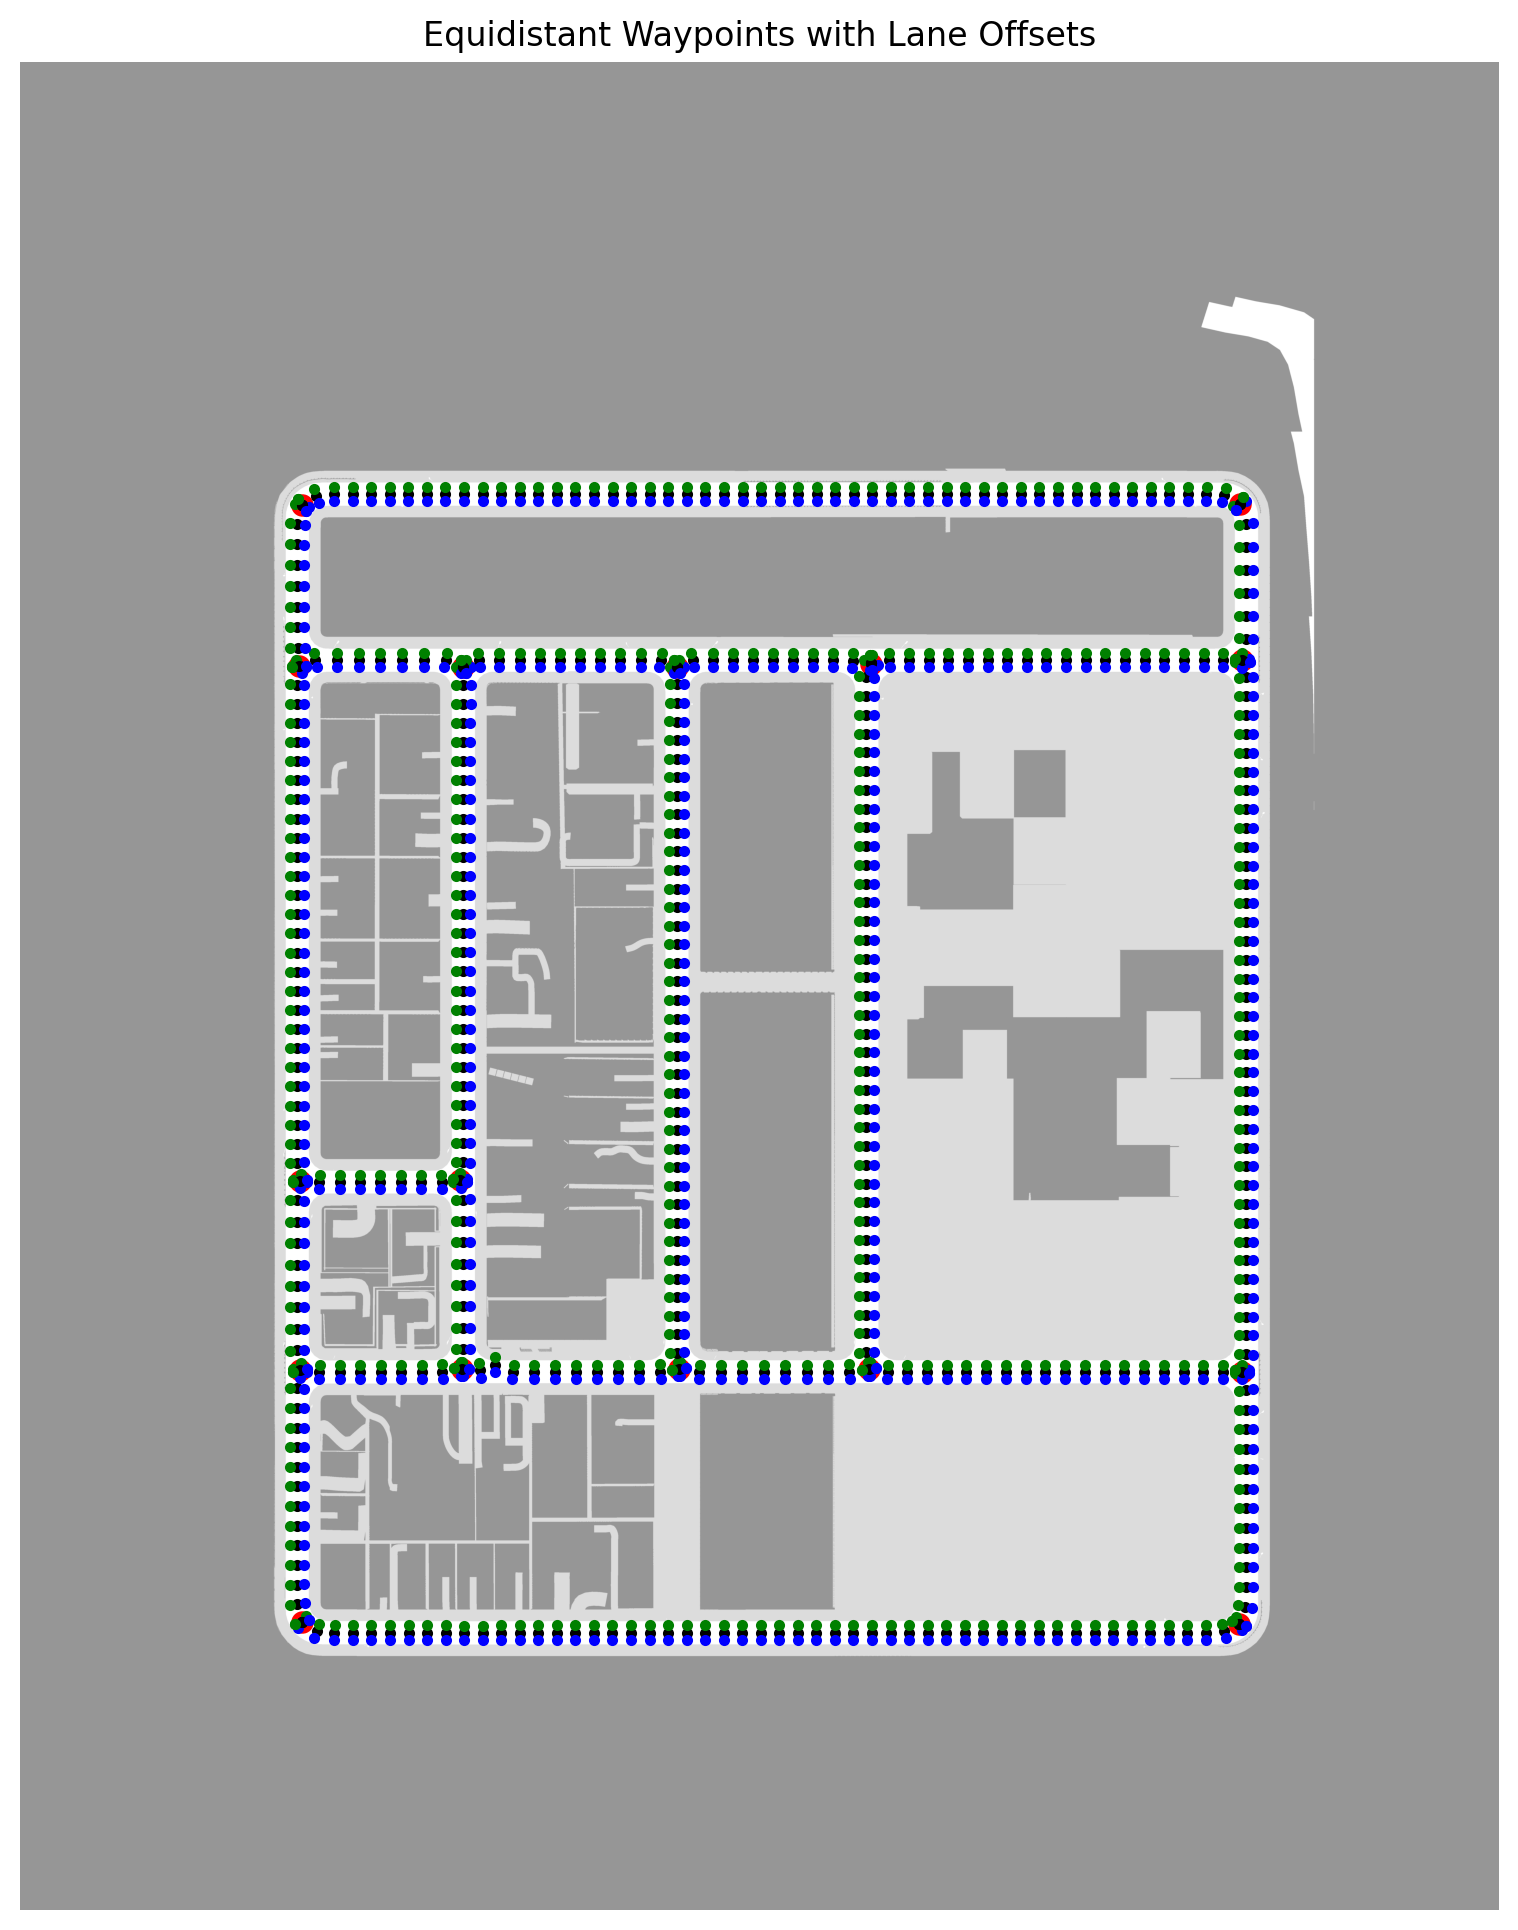

In [76]:
# --- Optional: Visualization ---
plt.imshow(rgbmap)
for idx, p in enumerate(intersections):
    plt.scatter(p[0], p[1], c='red', s=50)

for node_id in G_center.nodes:
    try:
        pos = G_center.nodes[node_id]['pos']
        plt.plot(pos[0], pos[1], 'k.', linewidth=0.3)

        id_l = node_id.replace("C", "L")
        id_r = node_id.replace("C", "R")

        pos = G_left.nodes[id_l]['pos']
        plt.plot(pos[0], pos[1], 'b.', linewidth=0.1)
        pos = G_right.nodes[id_r]['pos']
        plt.plot(pos[0], pos[1], 'g.', linewidth=0.1)
    except:
        print(node_id)
        continue



plt.title("Equidistant Waypoints with Lane Offsets")
plt.axis('off')
plt.show()

In [ ]:
add_lane_waypoints_to_graph(G_planning, )

In [77]:
import pickle

# Save
with open("town01-center.pkl", "wb") as f:
    pickle.dump(G_center, f)

with open("town01-left.pkl", "wb") as f:
    pickle.dump(G_left, f)

with open("town01-right.pkl", "wb") as f:
    pickle.dump(G_right, f)



In [ ]:

# Load
with open("town01.pkl", "rb") as f:
    G_planning = pickle.load(f)
